# Normalisation and histogram equalisation of images

Images from microscopy systems tend to have arbitrary intensity ranges, because intensities depend on many different conditions out of the control of the user. Usually we do not have to care about it in image analysis - we just have to make sure that we deal with images in a standardised way, such that the methods do not become dependent on all these other conditions during image acquisition.

## Init

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My\ Drive/Cambioscience\ Image\ Analysis

/content/drive/My Drive/Cambioscience Image Analysis


## Normalisation

A common way to standardise data for processing is by normalisation. Normalisation usually is carried out by the operation: 

[ (whole image) - (mean value) ] / (standard deviation of image)

In this way the image data will be centred around zero and assuming the image data follows a normal distribution, 68 % of the values will be within [-1:1]

In [0]:
# Some functions we will need
from skimage import io
import numpy as np
import os

from math import sqrt
import h5py 
import matplotlib.pyplot as plt
from skimage import exposure


def plothistogram(img): 
    img_hist, bins = exposure.histogram(img)
    plt.plot(bins, img_hist / img_hist.max())
    img_cdf, bins = exposure.cumulative_distribution(img)
    plt.plot(bins, img_cdf)
    plt.xlabel('Grayscale value')
    plt.ylabel('Frequency')
    plt.legend(['Distribution','Cumulative'])

#### Example when used across dataset

In an image dataset instead of removing the mean of the individual image and dividing by the standard  deviation (std), we use the overall mean and std. For the imageset DIV2K those values can be found to be [0.4485, 0.4375, 0.4045], [0.2436, 0.2330, 0.2424] on a scale of 0 to 1 for each colour.

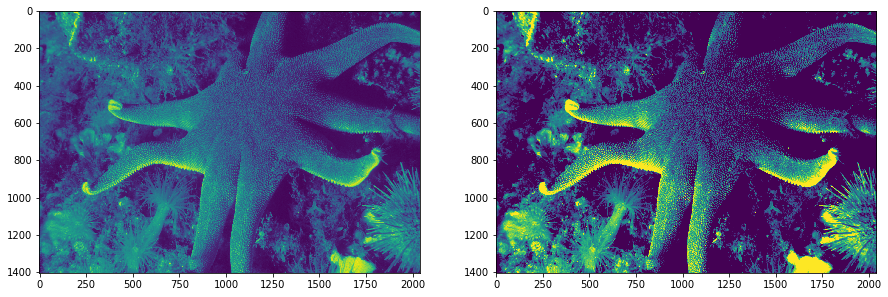

In [0]:
img1 = io.imread('Equalisation/0001.png')
img1 = img1.astype('float64') / np.max(img1)  # get it on 0 .. 1
img1_norm = (img1 - [0.4485, 0.4375, 0.4045]) / [0.2436, 0.2330, 0.2424]
img1, img1_norm = np.mean(img1,2), np.mean(img1_norm,2)  # get rid of colours for now

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img1_norm,vmin = -1,vmax = 1)
plt.show()

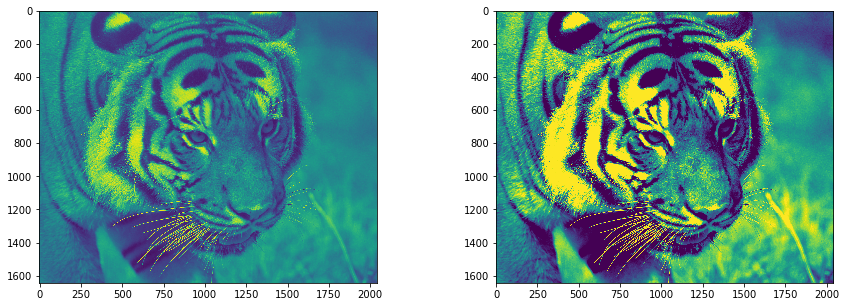

In [0]:
img2 = io.imread('Equalisation/0010.png')
img2 = img2.astype('float64') / np.max(img2)  # get it on 0 .. 1
img2_norm = (img2 - [0.4485, 0.4375, 0.4045]) / [0.2436, 0.2330, 0.2424]
img2, img2_norm = np.mean(img2,2), np.mean(img2_norm,2)  # get rid of colours for now

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(img2_norm,vmin = -1,vmax = 1)
plt.show()

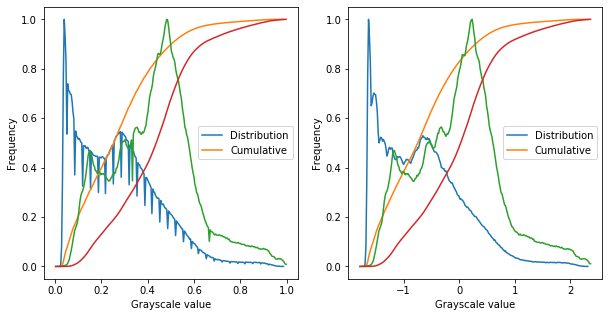

In [0]:
# plot histograms
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plothistogram(img1)
plothistogram(img2)
plt.subplot(1,2,2)
plothistogram(img1_norm)
plothistogram(img2_norm)

By comparing the cumulative distributions, we see that these very different images are now more comparable, i.e. the 50th percentile of the image content is at 0 in both normalised cases, whereas it is at more arbitrary values before normalisation (about 0.2 and 0.4 respectively). Now that they are standardised the images work better under the same model. 

#### Example

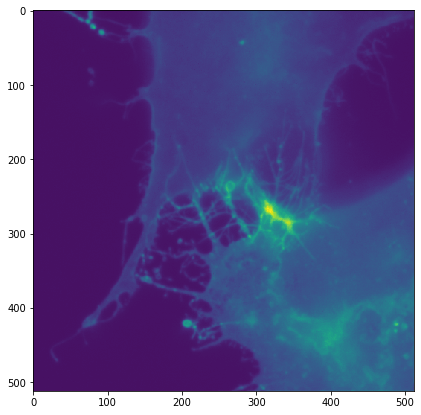

In [0]:
img_stack = io.imread("SIM/Miscellaneous/AtheiSIM 14-52_488.tif")

# This image stack has 9 frames. 
# As a structured illumination microscopy image,
# we can take the mean to get a wide-field equivalent

widefield = np.mean(img_stack,0)
widefield = widefield / np.max(widefield) # let's squeeze into 0 .. 1

plt.figure(figsize=(7,7))
plt.imshow(widefield,vmin=0,vmax=1)

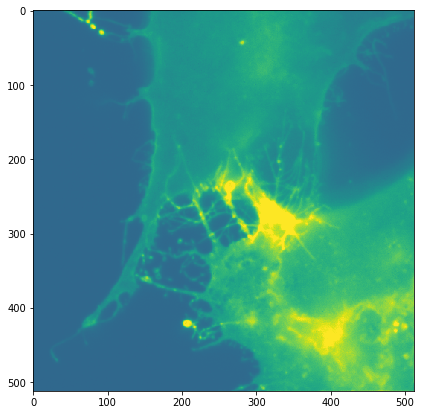

In [0]:
# normalisation
widefield_norm = (widefield - np.mean(widefield)) / np.std(widefield)
plt.figure(figsize=(7,7))
plt.imshow(widefield_norm,vmin=-3,vmax=3)

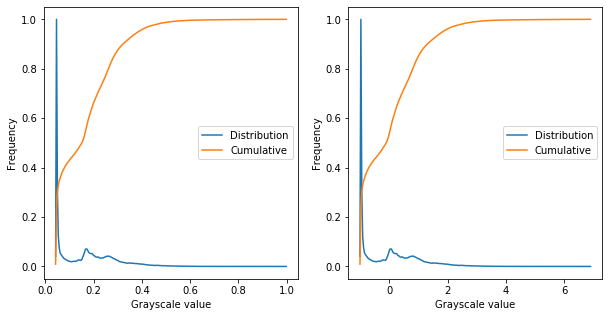

In [0]:
# plot histograms
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plothistogram(widefield)
plt.subplot(1,2,2)
plothistogram(widefield_norm)

Does not really work - what can we do?

## Histogram equalisation for enhancing single images

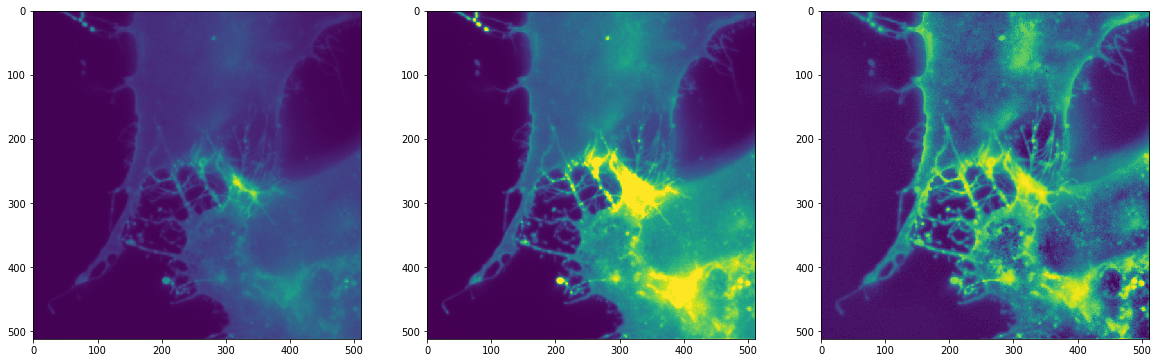

In [0]:
# We can use scikit-image for this

# Contrast stretching 
p2, p98 = np.percentile(widefield, (2, 98))
widefield_rescale = exposure.rescale_intensity(widefield, in_range=(p2, p98))

# Adaptive Equalization
widefield_adapthist = exposure.equalize_adapthist(widefield, clip_limit=0.03)

# plot
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(widefield)
plt.subplot(1,3,2)
plt.imshow(widefield_rescale)
plt.subplot(1,3,3)
plt.imshow(widefield_adapthist)
plt.show()